In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pyplot
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer

In [25]:
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target

In [26]:
# 데이터 셋 분할
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [27]:
data = torch.from_numpy(df.values).float()
x = data[:,:-1]
y = data[:,-1:]
x.shape, y.shape

(torch.Size([569, 30]), torch.Size([569, 1]))

In [28]:
rations = [.6, .2, .2]
train_cnt = int(data.size(0)*rations[0])
valid_cnt = int(data.size(0)*rations[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]
cnts

[341, 113, 115]

In [29]:
# 랜덤하게 섞어서 나눠준다
idx = torch.randperm(data.size(0))
x = torch.index_select(x, dim=0, index=idx)
y = torch.index_select(y, dim=0, index=idx)
x = x.split(cnts, dim=0)
y = y.split(cnts, dim=0)

In [30]:
x[0].size(), y[0].size()

(torch.Size([341, 30]), torch.Size([341, 1]))

In [31]:
# 학습데이터를 기준으로 표준 스케일링을 수행하고 나머지 데이터셋에 적용
scaler = StandardScaler()
scaler.fit(x[0].numpy())

x=[ torch.from_numpy(scaler.transform(x[0].numpy())).float(),
    torch.from_numpy(scaler.transform(x[1].numpy())).float(),
    torch.from_numpy(scaler.transform(x[2].numpy())).float()
]

In [32]:
class MyModel(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MyModel,self).__init__()
    self.n1 = nn.Linear(input_dim, 25)
    self.n2 = nn.Linear(25, 20)
    self.n3 = nn.Linear(20, 15)
    self.n4 = nn.Linear(15, 10)
    self.n5 = nn.Linear(10, 5)
    self.n6 = nn.Linear(5, output_dim)
    self.lk = nn.LeakyReLU()
    self.sig = nn.Sigmoid()
  def forward(self, x):
    x = self.lk(self.n1(x))
    x = self.lk(self.n2(x))
    x = self.lk(self.n3(x))
    x = self.lk(self.n4(x))
    x = self.lk(self.n5(x))
    x = self.sig(self.n6(x))
    return x

In [33]:
model = MyModel(x[0].size(-1), y[0].size(-1))
op = optim.Adam(model.parameters(), lr = 1e-2)

In [34]:
n_epochs = 10000
batch_size = 256
lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf
train_history,valid_history = [],[]
eary_stop = 100

In [35]:
for i in range(n_epochs):
  # 학습을 위해서 데이터를 섞는다.
  indices = torch.randperm(x[0].size(0))
  x_ = torch.index_select(x[0], dim=0, index=indices)
  y_ = torch.index_select(y[0], dim=0, index=indices)

  x_ = x_.split(batch_size, dim=0)
  y_ = y_.split(batch_size, dim=0)

  train_loss, valid_loss = 0,0
  y_hat = []

  for x_i, y_i in zip(x_, y_):
    y_hat_i = model(x_i)
    loss = F.binary_cross_entropy(y_hat_i, y_i)
    op.zero_grad()
    loss.backward()
    op.step()
    train_loss += float(loss)
  train_loss = train_loss / len(x_)

  # 배치단위의 학습이 끝났으므로 이때 만들어진 모델을 가지고 
  # valid데이터에 적용해서 값을 측정
  # 이때 평가용이기 때문에.. 학습이 되면 안됨.. 즉... 가중치 업데이트 안함- 미분x 
  # 역전파가 없으므로 backward가 없음
  with torch.no_grad():
    x_ = x[1].split(batch_size,dim=0)
    y_ = y[1].split(batch_size,dim=0)
    valid_loss = 0
    for x_i, y_i in zip(x_, y_):
      y_hat_i = model(x_i)
      loss = F.binary_cross_entropy(y_hat_i, y_i)
      valid_loss += loss
      y_hat += [y_hat_i]
  valid_loss = valid_loss / len(x_)

  train_history += [train_loss]
  valid_history += [valid_loss]

  if i % 100 ==0:
    print(f"epoch:{i+1} train loss:{train_loss} valid loss:{valid_loss} lowest loss:{lowest_loss}")
  
  if valid_loss < lowest_loss:
    lowest_loss = valid_loss
    lowest_epoch = i
    best_model = deepcopy(model.state_dict())
  # elif eary_stop > 0 and lowest_epoch + eary_stop < i+1:
  #   print("no improvement")

print(f"best validation loss from epoch {lowest_epoch+1}  loss:{lowest_loss}")

epoch:1 train loss:0.6946715116500854 valid loss:0.6806467771530151 lowest loss:inf
epoch:101 train loss:5.482233427756e-05 valid loss:0.1305287480354309 lowest loss:0.04450720548629761
epoch:201 train loss:9.72217412709142e-06 valid loss:0.14765672385692596 lowest loss:0.04450720548629761
epoch:301 train loss:4.492848347581457e-06 valid loss:0.8928232789039612 lowest loss:0.04450720548629761
epoch:401 train loss:2.1642902652274643e-06 valid loss:0.8939434289932251 lowest loss:0.04450720548629761
epoch:501 train loss:1.1953866589919926e-06 valid loss:0.8955878019332886 lowest loss:0.04450720548629761
epoch:601 train loss:7.956794831898151e-07 valid loss:0.8962500691413879 lowest loss:0.04450720548629761
epoch:701 train loss:8.34504930935509e-07 valid loss:0.8968852758407593 lowest loss:0.04450720548629761
epoch:801 train loss:5.428987606137525e-07 valid loss:0.8980541825294495 lowest loss:0.04450720548629761
epoch:901 train loss:3.1718018789206326e-07 valid loss:0.8987599015235901 lowe

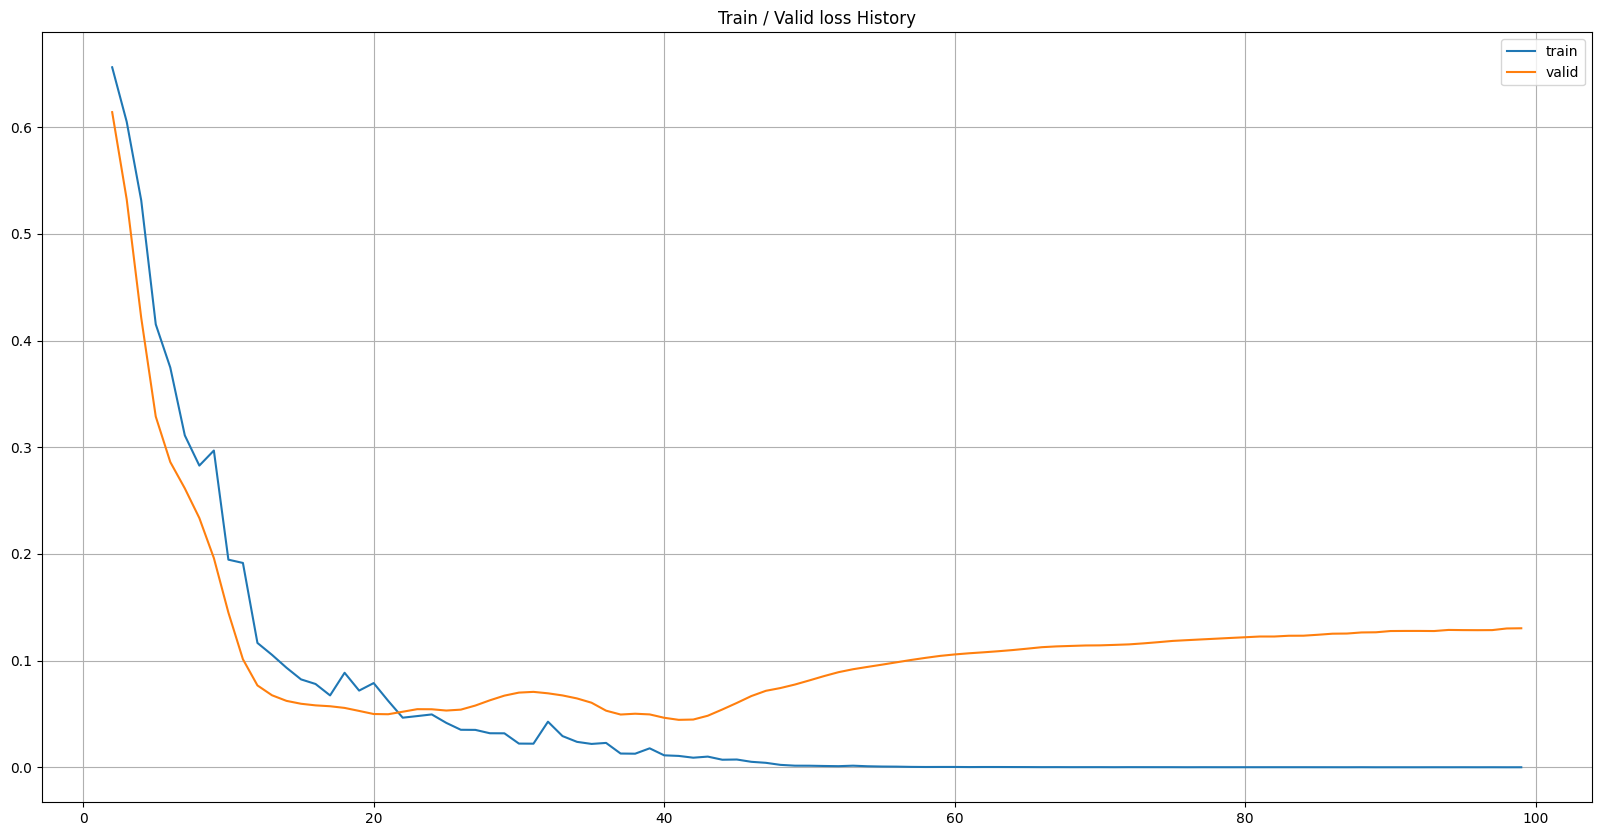

In [45]:
# 손실곡선 확인
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (20,10) )
plt.grid(True)
plt.title('Train / Valid loss History')
plt.plot(list(range(2,100)) , train_history[2:100] , label = 'train')
plt.plot(list(range(2,100)) , valid_history[2:100] , label = 'valid')
plt.legend()
plt.show()

In [46]:
# 테스트 데이터를 통해 결과를 확인
# 테스트 데이터로 확인
model.load_state_dict(best_model)


test_loss = 0
y_hat = []
with torch.no_grad():
  x_ = x[2].split(batch_size, dim=0)
  y_ = y[2].split(batch_size, dim=0)
  for x_i, y_i in zip(x_,y_):
    y_hat_i = model(x_i)
    loss = F.binary_cross_entropy(y_hat_i, y_i)
    test_loss += loss
    y_hat += [y_hat_i]
test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)
sorted_history = sorted(zip(train_history, valid_history), key = lambda x: x[1])
print(f'Train loss : {sorted_history[0][0]:.4e}')
print(f'Valid loss : {sorted_history[0][1]:.4e}')
print(f'Test loss : {test_loss:.4e}')

Train loss : 1.0701e-02
Valid loss : 4.4507e-02
Test loss : 8.7352e-01


In [48]:
# 회귀가 아니라 정확도를 측정... sigmoid - > 0.5보다 크다 작다
correct_cnt = (y[2] == (y_hat > .5)).sum()
total_cnt = float(y[2].size(0))
accuracy = correct_cnt / total_cnt
print(f"test accuracy : {accuracy:.4f}")

test accuracy : 0.9913


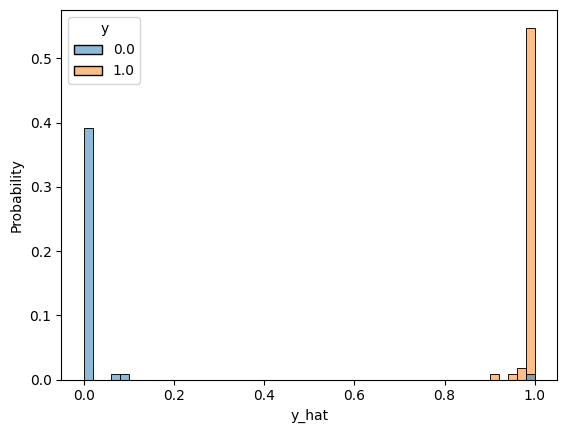

In [49]:
df = pd.DataFrame(torch.cat([y[2],y_hat ], dim=1).detach().numpy(), columns=['y','y_hat']  )
sns.histplot(df, x='y_hat', hue='y', bins = 50, stat='probability')
plt.show()

In [24]:
# 다중 분류  - 이미지
from torchvision import datasets,  transforms
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy


In [25]:
train = datasets.MNIST(
    './data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
test = datasets.MNIST(
    './data', train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [26]:
def plot(x):
  img = (np.array(x.detach().cpu(), dtype='float')).reshape(28,28)
  plt.imshow(img,cmap='gray')
  plt.axis('off')
  plt.show()

In [27]:
x = train.data.float() / 255
y = train.targets
x = x.view(x.size(0),-1)
x.size(), y.size()

(torch.Size([60000, 784]), torch.Size([60000]))

In [28]:
# 딥러닝 모델을 위해서 입력과 출력의 크기를 자동으로 계산
input_size = x.size(-1)
output_size = int(max(y))+1

In [29]:
input_size, output_size

(784, 10)

In [30]:
type(x)

torch.Tensor

In [31]:
# 8:2로 학습과 검증
rations = [.8, .2]
train_cnt = int(x.size(0)*rations[0])
valid_cnt = int(x.size(0)*rations[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]
print(cnts)
# idx = torch.randperm(x.size(0))
# x = torch.index_select(x, dim=0 ,index=idx)
# y = torch.index_select(y, dim=0 ,index=idx)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x +=[(test.data.float() / 255).view(test_cnt,-1)]
y += [test.targets]

for x_i, y_i in zip(x,y):
  print(x_i.size(), y_i.size())

[48000, 12000]
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [32]:
# 학습코드 구현
class MyModel(nn.Module):  
  def __init__(self, input_dim, output_dim):    
    super(MyModel,self).__init__()
    self.n1 = nn.Linear(input_dim, 500)
    self.n2 = nn.Linear(500, 400)
    self.n3 = nn.Linear(400, 300)
    self.n4 = nn.Linear(300, 200)
    self.n5 = nn.Linear(200, 100)
    self.n6 = nn.Linear(100, 50)
    self.n7 = nn.Linear(50, output_dim)
    self.lk = nn.LeakyReLU()
    self.softmax = nn.LogSoftmax(dim = -1)
  def forward(self, x):
    x = self.lk(self.n1(x))
    x = self.lk(self.n2(x))
    x = self.lk(self.n3(x))
    x = self.lk(self.n4(x))
    x = self.lk(self.n5(x))
    x = self.lk(self.n6(x))
    x = self.softmax(self.n7(x))
    return x

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

model = MyModel(x[0].size(-1),y[0].size(-1))
model = model.to(device)

op = optim.Adam(model.parameters())
crit = nn.NLLLoss()

In [37]:
n_epochs = 10
batch_size = 256
lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf
train_history,valid_history = [],[]
eary_stop = 100

In [ ]:
for i in range(n_epochs):
  # 학습을 위해서 데이터를 섞는다.
  indices = torch.randperm(x[0].size(0)).to(device)
  x_ = torch.index_select(x[0], dim=0, index=indices)
  y_ = torch.index_select(y[0], dim=0, index=indices)

  x_ = x_.split(batch_size, dim=0)
  y_ = y_.split(batch_size, dim=0)

  train_loss, valid_loss = 0,0
  y_hat = []

  for x_i, y_i in zip(x_, y_):
    y_hat_i = model(x_i)
    loss = crit(y_hat_i, y_i.squeeze())
    op.zero_grad()
    loss.backward()
    op.step()
    train_loss += float(loss)
  train_loss = train_loss / len(x_)

  # 배치단위의 학습이 끝났으므로 이때 만들어진 모델을 가지고 
  # valid데이터에 적용해서 값을 측정
  # 이때 평가용이기 때문에.. 학습이 되면 안됨.. 즉... 가중치 업데이트 안함- 미분x 
  # 역전파가 없으므로 backward가 없음
  with torch.no_grad():
    x_ = x[1].split(batch_size,dim=0)
    y_ = y[1].split(batch_size,dim=0)
    valid_loss = 0
    for x_i, y_i in zip(x_, y_):
      y_hat_i = model(x_i)
      loss = crit(y_hat_i, y_i.squeeze())
      valid_loss += loss
      y_hat += [y_hat_i]
  valid_loss = valid_loss / len(x_)

  train_history += [train_loss]
  valid_history += [valid_loss]

  if i % 100 ==0:
    print(f"epoch:{i+1} train loss:{train_loss} valid loss:{valid_loss} lowest loss:{lowest_loss}")
  
  if valid_loss < lowest_loss:
    lowest_loss = valid_loss
    lowest_epoch = i
    best_model = deepcopy(model.state_dict())
  # elif eary_stop > 0 and lowest_epoch + eary_stop < i+1:
  #   print("no improvement")

print(f"best validation loss from epoch {lowest_epoch+1}  loss:{lowest_loss}")

epoch:1 train loss:2.2330506776083023 valid loss:0.3422965407371521 lowest loss:inf
